In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

from src.models_classical.utils import (
    under_over_sampler,
    scale_data,
    calculate_scores,
    collate_scores_binary_classification,
    get_classifier_and_params,
    get_model_metrics_df,
)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from src.visualization.visualize import plot_pr_roc_curves_kfolds

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
proj_dir = Path().cwd().parent.parent
print(proj_dir)

path_emb_dir = proj_dir / "data" / "processed" / "embeddings"
path_model_dir = proj_dir / "models" / "final_results_classical" / "model_files"

/home/tim/Documents/arxiv-code-search


In [3]:
emb_file = "df_embeddings_other.pkl"
model_file = "model_12082548_rf_2022-06-07-2249-15_papers1.pkl"
scaler_file = "scaler_12082548_rf_2022-06-07-2249-15_papers1.pkl"

# load dfh.pickle
with open(path_emb_dir / emb_file, "rb") as f:
    df = pickle.load(f)

# load sklearn scaler from scaler file
with open(path_model_dir / scaler_file, "rb") as f:
    scaler = pickle.load(f)

# load the model
with open(path_model_dir / model_file, "rb") as f:
    model = pickle.load(f)

In [4]:
df.head()

,label,id,para,h
0,0,10.1016_j.ymssp.2015.05.028,"; q ðjþ; rðjþg and the observation set yn, a d...","[-0.6470553874969482, 0.6207976341247559, 0.05..."
1,0,10.1016_j.ymssp.2015.05.028,forward filtered data. therefore the smoothed ...,"[-0.513788640499115, 0.20524263381958008, -0.5..."
2,0,10.1016_j.ymssp.2016.04.028,the benchmark methods,"[-0.621538519859314, -0.34547579288482666, -0...."
3,0,10.1016_j.ymssp.2016.04.028,3.3. results comparison with a benchmark study,"[-0.5140003561973572, -0.8636043667793274, 0.2..."
4,0,10.1016_j.ymssp.2016.04.028,table 3 results comparison with the benchmark ...,"[-0.06085033714771271, -0.19399628043174744, 0..."


In [5]:
df["label"].unique()

array([0, 1])

In [7]:
x_test = np.array([e for e in df["h"].values])
y_test = df["label"].values
print(np.max(x_test))

x_test = scaler.transform(x_test)
print(np.max(x_test))

16.70672035217285
5.186684776765523


In [8]:
ind_score_dict = calculate_scores(model, x_test, y_test)

In [10]:
trained_result_dict = collate_scores_binary_classification([ind_score_dict])

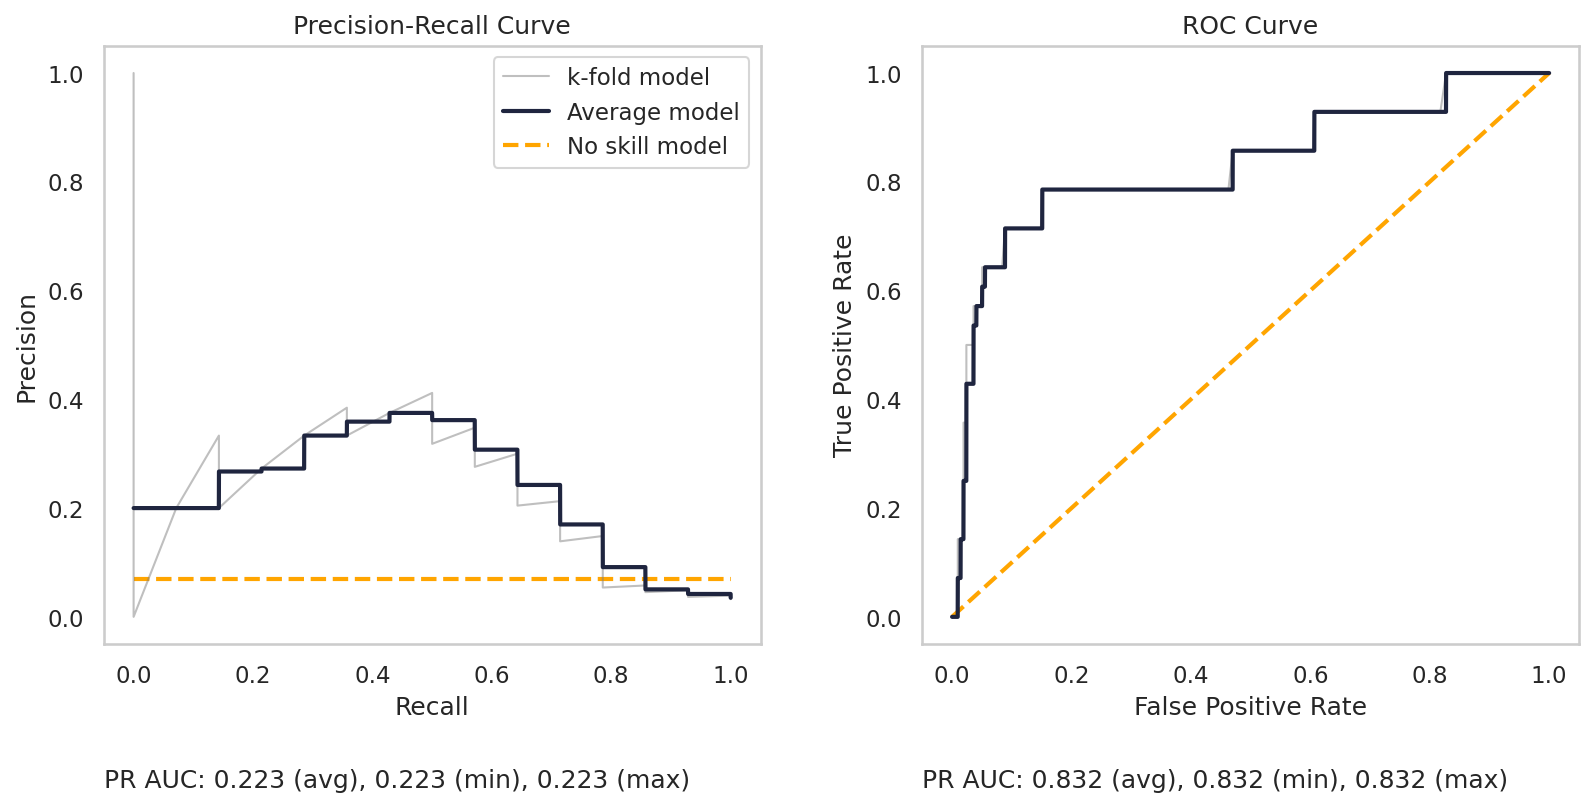

In [13]:
plot_pr_roc_curves_kfolds(
    trained_result_dict["precisions_array"],
    trained_result_dict["recalls_array"],
    trained_result_dict["fpr_array"],
    trained_result_dict["tpr_array"],
    trained_result_dict["rocauc_array"],
    trained_result_dict["prauc_array"],
    percent_anomalies_truth=0.07,
    save_plot=False,
    dpi=300,
)